## Lazy FCA
Autor: Potapov Ivan

I've choosen dataset from [Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?resource=download) on loan applications with marked approval flags, which we will learn to predict. The dataset has 45k objects and 14 features, which we will transform into more binery features later.

# Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/loan_data.csv')
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
features = ['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file']

target = 'loan_status'

X = data[features]
y = data[target].squeeze()

# Data Analysis

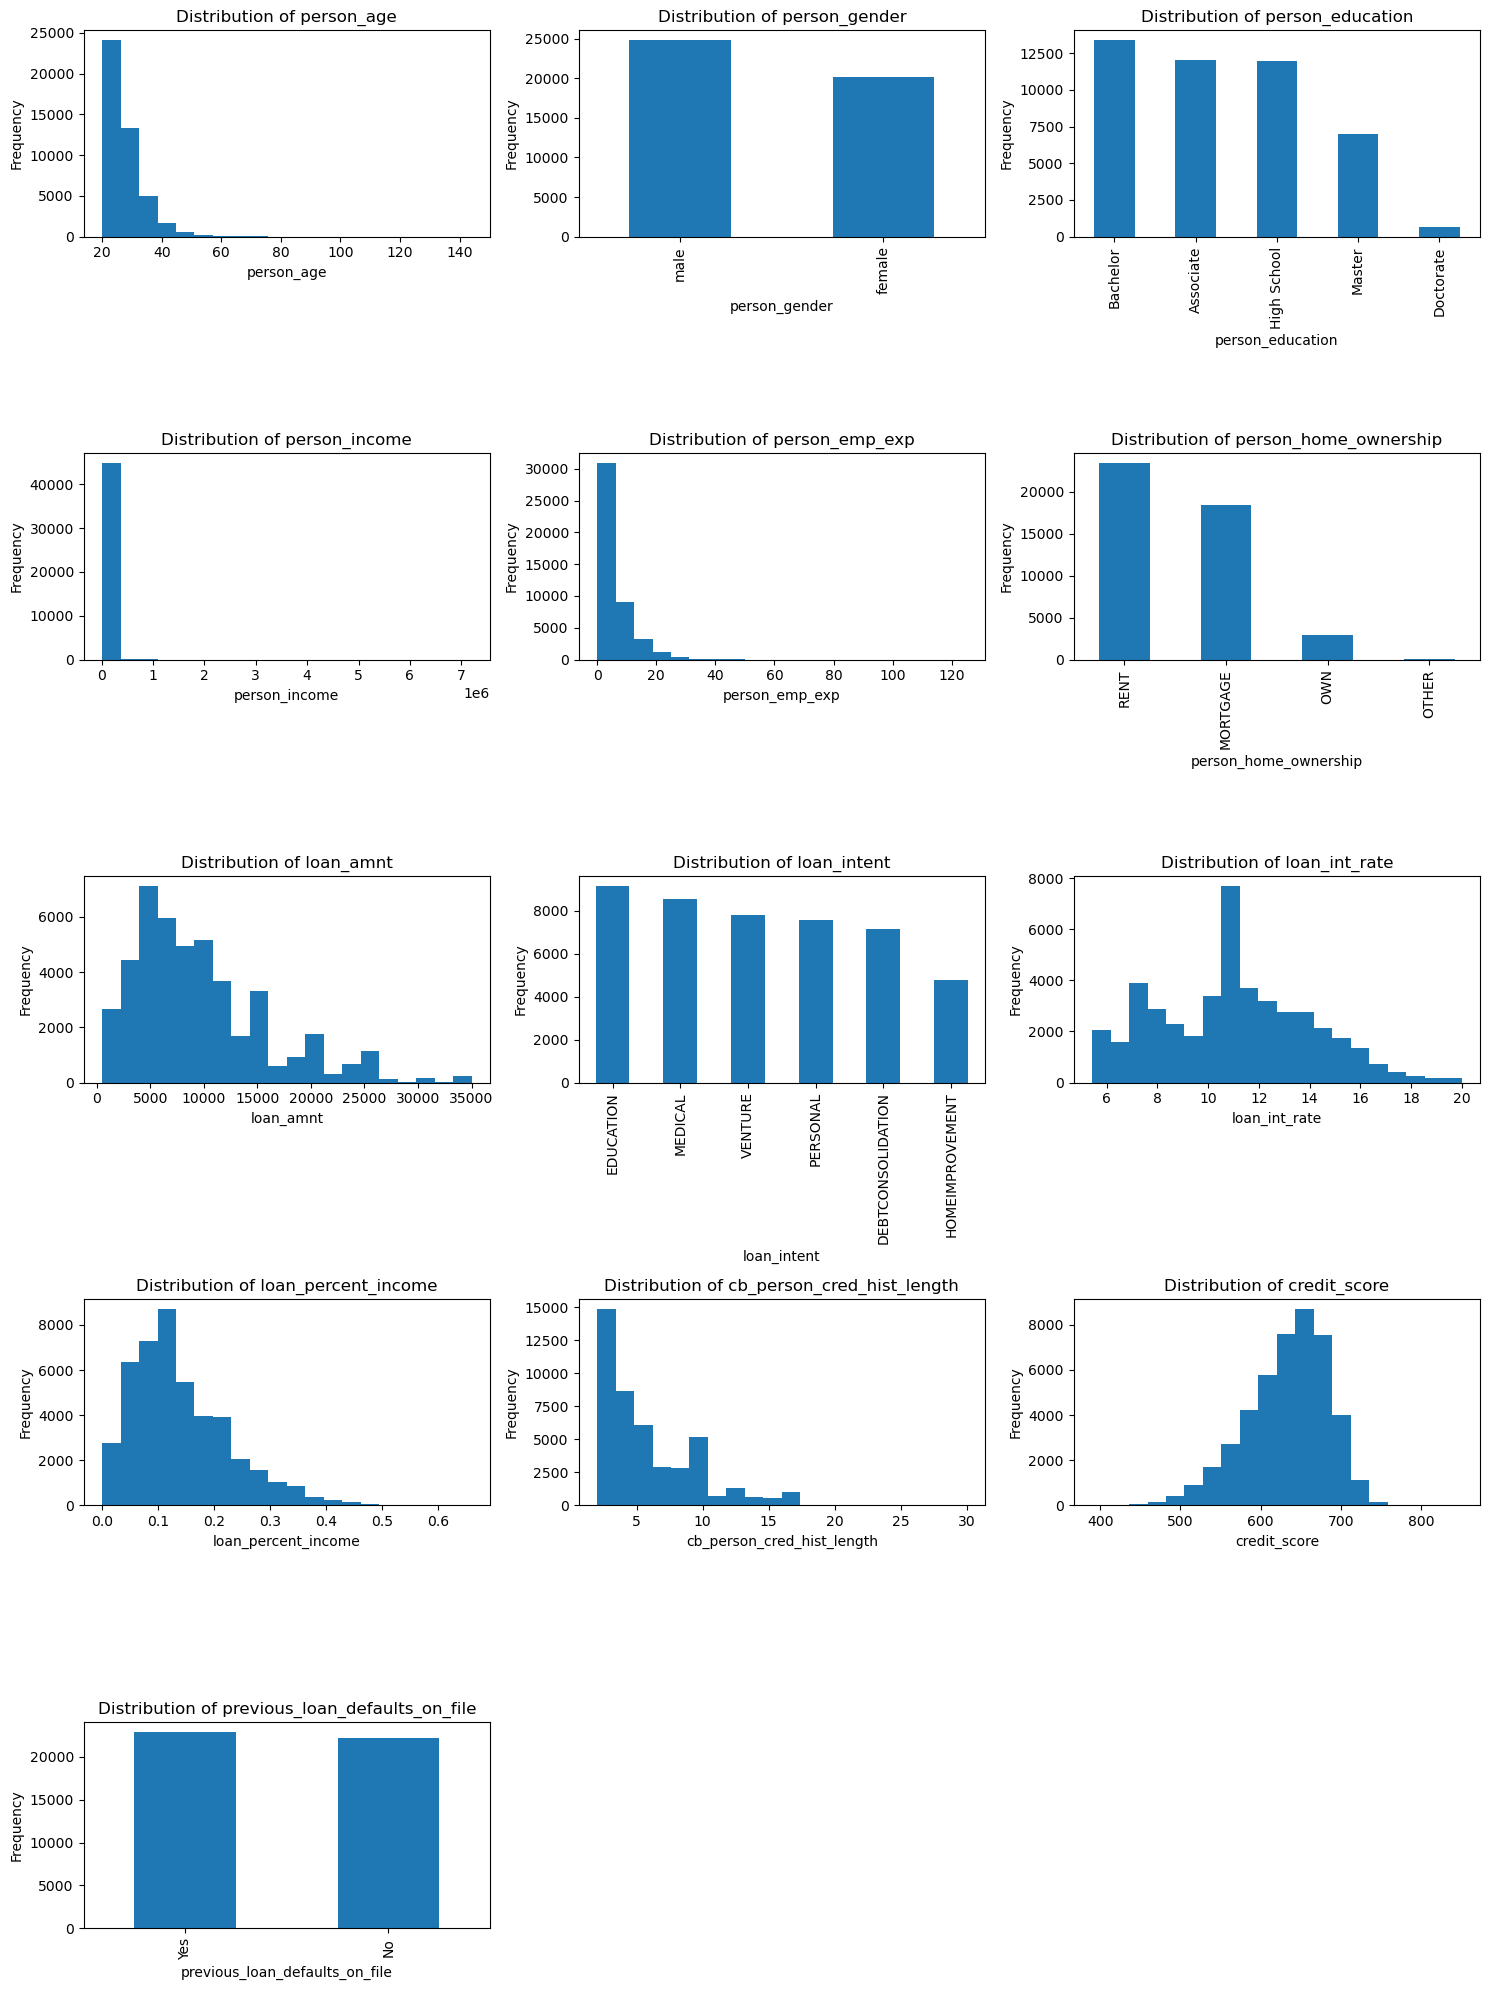

In [6]:
num_columns = len(data.columns)
cols = 3  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_columns / cols)

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, column in enumerate(X.columns):
    ax = axes[i]
    if X[column].dtype == 'object' or len(X[column].unique()) < 20:
        # For categorical or discrete features, use a bar plot
        X[column].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
    else:
        # For continuous features, use a histogram
        X[column].plot(kind='hist', bins=20, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for readability
plt.show()

In [7]:
y.value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

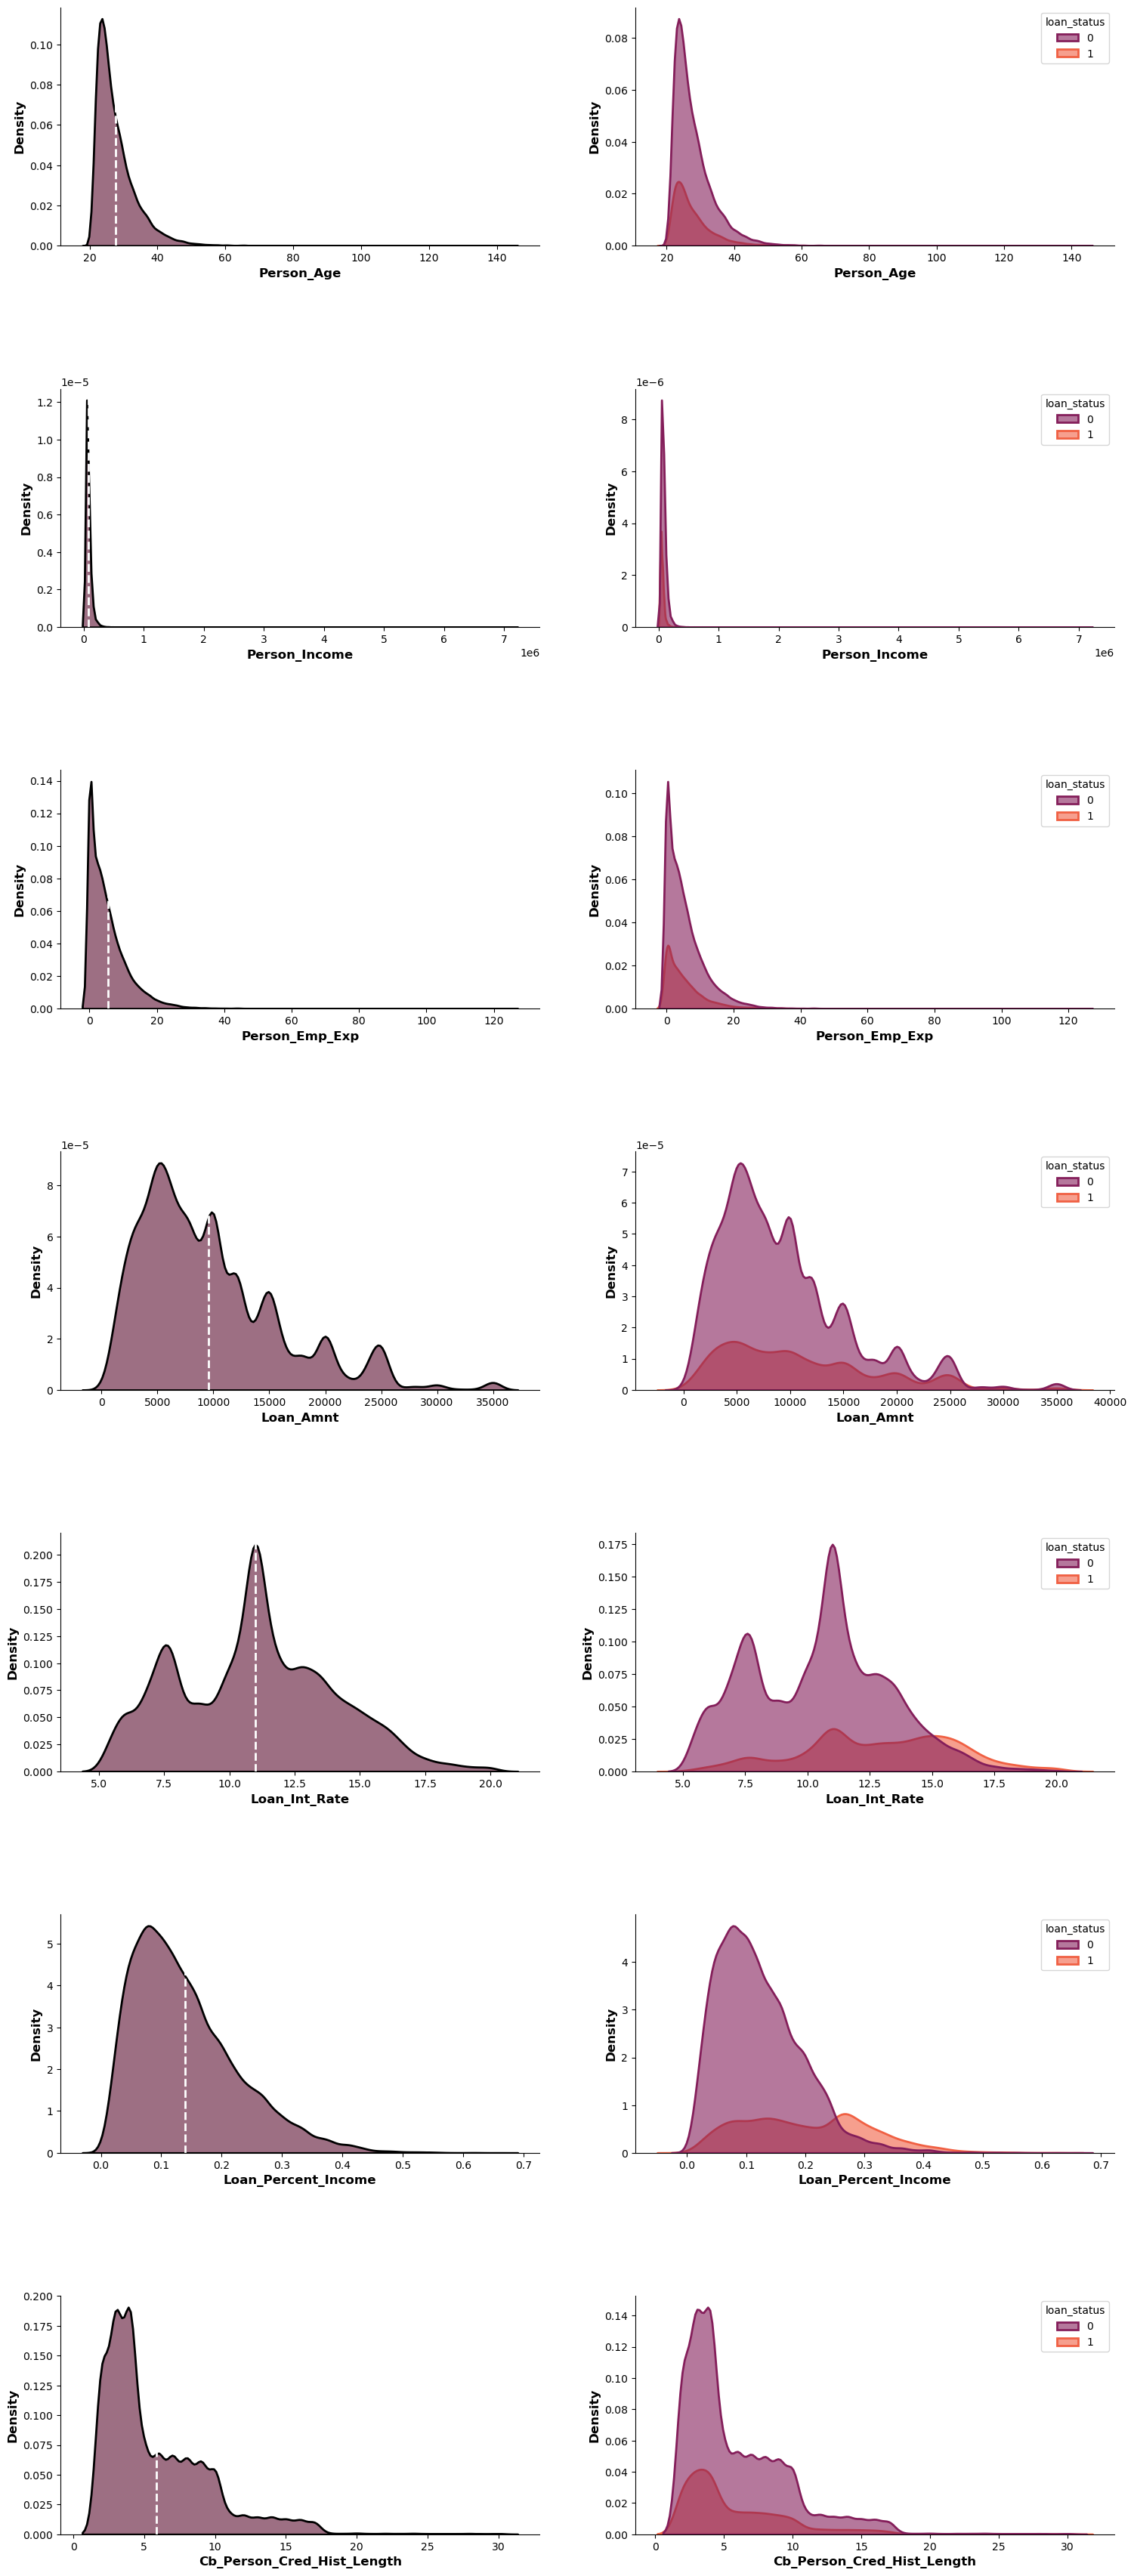

In [8]:
numeric_features = ['person_age', 'person_income',
       'person_emp_exp','loan_amnt', 
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score']

X_cur = X[numeric_features]

plotIndex = 1
plt.figure(figsize=(18,50))
for i in range(1, len(X_cur.columns)):
    plt.subplot(len(X_cur.columns), 2, plotIndex)
    sns.kdeplot(data=X_cur, x=X_cur.columns[i-1], 
                fill=True, linewidth=2, color='#5c1031', alpha=0.6, edgecolor='k')
    plt.axvline(X[X_cur.columns[i-1]].mean(), color='white', linestyle='--', linewidth=2)
    plt.xlabel(xlabel=X_cur.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    plt.subplot(len(X_cur.columns), 2, plotIndex+1)
    sns.kdeplot(data=X_cur, x=X_cur.columns[i-1], 
                fill=True, hue=y, linewidth=2, palette='rocket', alpha=0.6)
    plt.xlabel(xlabel=X_cur.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
    plotIndex += 2
plt.subplots_adjust(hspace=0.6)    
plt.show()

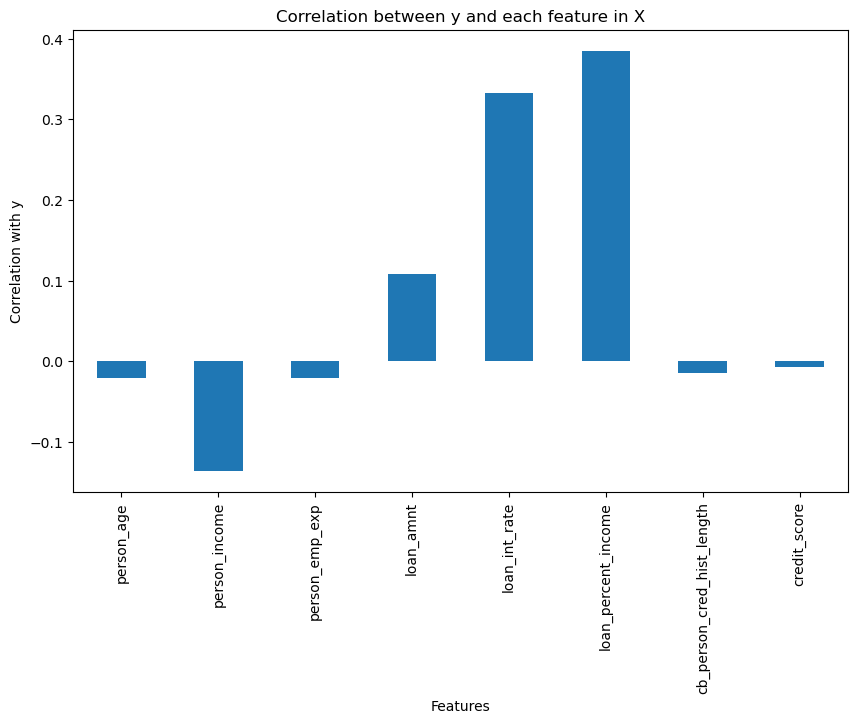

In [9]:
correlations = X_cur.corrwith(y)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation between y and each feature in X')
plt.xlabel('Features')
plt.ylabel('Correlation with y')
plt.show()

#  Data Preprocessing

In this notebook we only scale the initial data. We will try split numerical data into approximately equal parts.

In [10]:
X_scaled = pd.DataFrame(index=X.index)

#### 1. person_age

Age of the person

In [11]:
column = 'person_age'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(20.0, 144.0)

In [12]:
thresholds = [min_value, 20, 30, 40, 60, 80, max_value]

In [13]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 2. person_gender

Gender of the person

In [14]:
column = 'person_gender'

for value in X[column].unique():
    X_scaled[f'{column}_{value}'] = X[column] == value

#### 3. person_education

Highest education level

In [15]:
column = 'person_education'

for value in X[column].unique():
    X_scaled[f'{column}_{value}'] = X[column] == value

#### 4. person_income

Annual income

In [16]:
column = 'person_income'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(8000.0, 7200766.0)

In [17]:
thresholds = [min_value, 45_000, 60_000, 75_000, 100_000, max_value]

In [18]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 5. person_emp_exp

Years of employment experience

In [19]:
column = 'person_emp_exp'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(0, 125)

In [20]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 6. person_home_ownership

Home ownership status (e.g., rent, own, mortgage)

In [21]:
column = 'person_home_ownership'

for value in X[column].unique():
    X_scaled[f'{column}_{value}'] = X[column] == value

#### 7. loan_amnt

Loan amount requested

In [22]:
column = 'loan_amnt'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(500.0, 35000.0)

In [23]:
thresholds = [min_value, 4500, 6600, 10000, 15000, max_value]

In [24]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 8. loan_intent

Purpose of the loan

In [25]:
column = 'loan_intent'

for value in X[column].unique():
    X_scaled[f'{column}_{value}'] = X[column] == value

#### 9. loan_int_rate

Loan interest rate

In [26]:
column = 'loan_int_rate'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(5.42, 20.0)

In [27]:
thresholds = [min_value, 8, 10, 12, 14, max_value]

In [28]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 10. loan_percent_income

Loan amount as a percentage of annual income

In [29]:
column = 'loan_percent_income'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(0.0, 0.66)

In [30]:
thresholds = [min_value, 0.06, 0.1, 0.15, 0.20, max_value]

In [31]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 11. cb_person_cred_hist_length

Length of credit history in years

In [32]:
column = 'cb_person_cred_hist_length'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(2.0, 30.0)

In [33]:
thresholds = [min_value, 3, 6, 9, max_value]

In [34]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 12. credit_score

Credit score of the person

In [35]:
column = 'credit_score'

min_value = X[column].min()
max_value = X[column].max()
min_value, max_value

(390, 850)

In [36]:
thresholds = [min_value, 590, 625, 650, 675, max_value]

In [37]:
for threshold in thresholds:
    X_scaled[f'{column}_le_{threshold}'] = X[column] <= threshold
    X_scaled[f'{column}_ge_{threshold}'] = X[column] >= threshold

#### 13. previous_loan_defaults_on_file

Indicator of previous loan defaults

In [38]:
column = 'person_home_ownership'

for value in X[column].unique():
    X_scaled[f'{column}_{value}'] = X[column] == value

In [39]:
X_scaled.shape

(45000, 113)

In [40]:
X_scaled.head()

,person_age_le_20.0,person_age_ge_20.0,person_age_le_20,person_age_ge_20,person_age_le_30,person_age_ge_30,person_age_le_40,person_age_ge_40,person_age_le_60,person_age_ge_60,person_age_le_80,person_age_ge_80,person_age_le_144.0,person_age_ge_144.0,person_gender_female,person_gender_male,person_education_Master,person_education_High School,person_education_Bachelor,person_education_Associate,person_education_Doctorate,person_income_le_8000.0,person_income_ge_8000.0,person_income_le_45000,person_income_ge_45000,person_income_le_60000,person_income_ge_60000,person_income_le_75000,person_income_ge_75000,person_income_le_100000,person_income_ge_100000,person_income_le_7200766.0,person_income_ge_7200766.0,person_emp_exp_le_8000.0,person_emp_exp_ge_8000.0,person_emp_exp_le_45000,person_emp_exp_ge_45000,person_emp_exp_le_60000,person_emp_exp_ge_60000,person_emp_exp_le_75000,person_emp_exp_ge_75000,person_emp_exp_le_100000,person_emp_exp_ge_100000,person_emp_exp_le_7200766.0,person_emp_exp_ge_7200766.0,person_home_ownership_RENT,person_home_ownership_OWN,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,loan_amnt_le_500.0,loan_amnt_ge_500.0,loan_amnt_le_4500,loan_amnt_ge_4500,loan_amnt_le_6600,loan_amnt_ge_6600,loan_amnt_le_10000,loan_amnt_ge_10000,loan_amnt_le_15000,loan_amnt_ge_15000,loan_amnt_le_35000.0,loan_amnt_ge_35000.0,loan_intent_PERSONAL,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION,loan_int_rate_le_5.42,loan_int_rate_ge_5.42,loan_int_rate_le_8,loan_int_rate_ge_8,loan_int_rate_le_10,loan_int_rate_ge_10,loan_int_rate_le_12,loan_int_rate_ge_12,loan_int_rate_le_14,loan_int_rate_ge_14,loan_int_rate_le_20.0,loan_int_rate_ge_20.0,loan_percent_income_le_0.0,loan_percent_income_ge_0.0,loan_percent_income_le_0.06,loan_percent_income_ge_0.06,loan_percent_income_le_0.1,loan_percent_income_ge_0.1,loan_percent_income_le_0.15,loan_percent_income_ge_0.15,loan_percent_income_le_0.2,loan_percent_income_ge_0.2,loan_percent_income_le_0.66,loan_percent_income_ge_0.66,cb_person_cred_hist_length_le_2.0,cb_person_cred_hist_length_ge_2.0,cb_person_cred_hist_length_le_3,cb_person_cred_hist_length_ge_3,cb_person_cred_hist_length_le_6,cb_person_cred_hist_length_ge_6,cb_person_cred_hist_length_le_9,cb_person_cred_hist_length_ge_9,cb_person_cred_hist_length_le_30.0,cb_person_cred_hist_length_ge_30.0,credit_score_le_390,credit_score_ge_390,credit_score_le_590,credit_score_ge_590,credit_score_le_625,credit_score_ge_625,credit_score_le_650,credit_score_ge_650,credit_score_le_675,credit_score_ge_675,credit_score_le_850,credit_score_ge_850
0,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,True,True,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,True,False,False,True,False,True,False,True,False,True,False,True,True,False,False,True,True,True,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False
1,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True,False,True,False,False,True,False,True,True,False,True,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False
2,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,Fal

In [96]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

ImportError: cannot import name 'deprecated' from 'typing_extensions' (/Users/i.s.potapov/anaconda3/lib/python3.9/site-packages/typing_extensions.py)

In [95]:
!pip install typing_extensions==4.5

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
pydantic 2.10.2 requires typing-extensions>=4.12.2, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.27.1 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [99]:
!pip install bitarray==2.7.5

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: bitarray
    Found existing installation: bitarray 3.0.0
    Uninstalling bitarray-3.0.0:
      Successfully uninstalled bitarray-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
caspailleur 0.2.1 requires bitarray>=3.0.0, but you have bitarray 2.7.5 which is incompatible.


In [88]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

NameError: name 'nl' is not defined